# Cong Workbook


### Import Libraries
Let's first import some stuff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install mysql-connector-python

In [86]:
import mysql.connector

In [87]:
con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

### Analysis #1: Box Office / ROI based on genre and season

In [88]:
tn = pd.DataFrame(pd.read_sql_query("""
SELECT * 
FROM movies.tn_movie_budgets""", con))

In [89]:
tn['domestic_gross'] = tn['domestic_gross'].str.replace('$','')   

In [90]:
tn['domestic_gross'] = tn['domestic_gross'].str.replace(',','')

In [91]:
tn['domestic_gross'] = tn['domestic_gross'].astype(float)

In [92]:
tn['domestic_gross']

0       760507625.0
1       241063875.0
2        42762350.0
3       459005868.0
4       620181382.0
           ...     
5777            0.0
5778        48482.0
5779         1338.0
5780            0.0
5781       181041.0
Name: domestic_gross, Length: 5782, dtype: float64

In [93]:
bom = pd.DataFrame(pd.read_sql_query("""
SELECT * 
FROM movies.bom_movie_gross""", con))

In [326]:
bom['domestic_gross']

0       415000000.0
1       334200000.0
2       296000000.0
3       292600000.0
4       238700000.0
           ...     
3382         6200.0
3383         4800.0
3384         2500.0
3385         2400.0
3386         1700.0
Name: domestic_gross, Length: 3387, dtype: float64

In [94]:
tmdb = pd.DataFrame(pd.read_sql_query("""
SELECT * 
FROM movies.tmdb_movies""", con))

In [95]:
imdb_title_basics = pd.DataFrame(pd.read_sql_query("""
SELECT 
	primary_title,
    genres
FROM movies.imdb_title_basics""", con))

In [364]:
imdb_title_basics

,primary_title,genres
0,Sunghursh,"Action,Crime,Drama"
1,One Day Before the Rainy Season,"Biography,Drama"
2,The Other Side of the Wind,Drama
3,Sabse Bada Sukh,"Comedy,Drama"
4,The Wandering Soap Opera,"Comedy,Drama,Fantasy"
...,...,...
146139,Kuambil Lagi Hatiku,Drama
146140,Rodolpho Teóphilo - O Legado de um Pioneiro,Documentary
146141,Dankyavar Danka,Comedy
146142,6 Gunn,


In [328]:
tmdb.columns

Index(['genre_ids', 'id', 'original_language', 'original_title', 'popularity',
       'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')

In [329]:
tmdb_bom = tmdb.join(bom.set_index('title'),
          on='original_title',
          how='outer',
          rsuffix='_bom')

In [330]:
tbt_org = tmdb_bom.join(tn.set_index('movie'),
              on='original_title',
              how='outer',
              rsuffix='_tn')

In [331]:
tbt_org.shape

(31786, 18)

In [332]:
tbt_org = tbt_org.reset_index()

In [333]:
tbt_org.iloc[[1,27000,30000], :]

,index,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,studio,domestic_gross,foreign_gross,year,id_tn,release_date_tn,production_budget,domestic_gross_tn,worldwide_gross
1,1.0,1,10191.0,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610.0,P/DW,217600000.0,277300000.0,2010.0,30.0,"Mar 26, 2010","$165,000,000",217581232.0,"$494,870,992"
27000,NaN,NaN,NaN,NaN,17 Girls,NaN,NaN,NaN,NaN,NaN,Strand,15100.0,186000.0,2012.0,NaN,NaN,NaN,NaN,NaN
30000,NaN,NaN,NaN,NaN,The Princess Bride,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,"Sep 25, 1987","$15,000,000",30857000.0,"$30,859,628"


In [334]:
tbt_org['domestic_gross']

0                NaN
1        217600000.0
2        312400000.0
3                NaN
4                NaN
            ...     
31781            NaN
31782            NaN
31783            NaN
31784            NaN
31785            NaN
Name: domestic_gross, Length: 31786, dtype: float64

In [335]:
type(tbt_org.iloc[1,12])

numpy.float64

In [336]:
tbt_org['domestic_gross'] = np.where(tbt_org['domestic_gross'].isna(), tbt_org['domestic_gross_tn'], tbt_org['domestic_gross']) 

In [337]:
tbt_org['release_date'] = np.where(tbt_org['release_date'].isna(), tbt_org['release_date_tn'], tbt_org['release_date']) 

In [338]:
tbt_org['release_date'] = pd.to_datetime(tbt_org['release_date']) 

In [339]:
tbt_org.head()

,index,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,studio,domestic_gross,foreign_gross,year,id_tn,release_date_tn,production_budget,domestic_gross_tn,worldwide_gross
0,0.0,0,12444.0,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1,10191.0,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610.0,P/DW,217600000.0,277300000.0,2010.0,30.0,"Mar 26, 2010","$165,000,000",217581232.0,"$494,870,992"
2,2.0,2,10138.0,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368.0,Par.,312400000.0,311500000.0,2010.0,15.0,"May 7, 2010","$170,000,000",312433331.0,"$621,156,389"
3,3.0,3,862.0,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174.0,NaN,191796233.0,NaN,NaN,37.0,"Nov 22, 1995","$30,000,000",191796233.0,"$364,545,516"
4,2473.0,2473,862.0,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174.0,NaN,191796233.0,NaN,NaN,37.0,"Nov 22, 1995","$30,000,000",191796233.0,"$364,545,516"


In [341]:
tbt_new = tbt_org.drop(columns=['domestic_gross_tn','title', 'release_date_tn', 'index','id','year','id_tn', 'genre_ids'])

In [342]:
tbt_new = tbt_new.drop_duplicates(subset = 'original_title')

In [343]:
tbt_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29990 entries, 0 to 31785
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_language  24835 non-null  object        
 1   original_title     29990 non-null  object        
 2   popularity         24835 non-null  float64       
 3   release_date       28625 non-null  datetime64[ns]
 4   vote_average       24835 non-null  float64       
 5   vote_count         24835 non-null  float64       
 6   studio             3386 non-null   object        
 7   domestic_gross     7820 non-null   float64       
 8   foreign_gross      2037 non-null   float64       
 9   production_budget  5698 non-null   object        
 10  worldwide_gross    5698 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 2.7+ MB


In [344]:
tbt_new = tbt_new.dropna(subset=['domestic_gross'])

In [345]:
tbt_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7820 entries, 1 to 31785
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_language  2683 non-null   object        
 1   original_title     7820 non-null   object        
 2   popularity         2683 non-null   float64       
 3   release_date       6473 non-null   datetime64[ns]
 4   vote_average       2683 non-null   float64       
 5   vote_count         2683 non-null   float64       
 6   studio             3360 non-null   object        
 7   domestic_gross     7820 non-null   float64       
 8   foreign_gross      2011 non-null   float64       
 9   production_budget  5698 non-null   object        
 10  worldwide_gross    5698 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 733.1+ KB


In [349]:
tbt_new = tbt_new.dropna(subset=['production_budget'])

In [350]:
tbt_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5698 entries, 1 to 31785
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_language  1908 non-null   object        
 1   original_title     5698 non-null   object        
 2   popularity         1908 non-null   float64       
 3   release_date       5698 non-null   datetime64[ns]
 4   vote_average       1908 non-null   float64       
 5   vote_count         1908 non-null   float64       
 6   studio             1238 non-null   object        
 7   domestic_gross     5698 non-null   object        
 8   foreign_gross      1079 non-null   float64       
 9   production_budget  5698 non-null   object        
 10  worldwide_gross    5698 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(6)
memory usage: 534.2+ KB


In [353]:
tbt_new['worldwide_gross'] = tbt_new['worldwide_gross'].str.replace('$','') 

In [354]:
tbt_new['worldwide_gross'] = tbt_new['worldwide_gross'].str.replace(',','') 

In [355]:
tbt_new['worldwide_gross'] = tbt_new['worldwide_gross'].astype(float)

In [356]:
tbt_new['worldwide_gross']

1        494870992.0
2        621156389.0
3        364545516.0
5        835524642.0
6        223050874.0
            ...     
31781            0.0
31782       240495.0
31783         1338.0
31784            0.0
31785       181041.0
Name: worldwide_gross, Length: 5698, dtype: float64

In [357]:
tbt_new.isna().sum()

original_language    3790
original_title          0
popularity           3790
release_date            0
vote_average         3790
vote_count           3790
studio               4460
domestic_gross          0
foreign_gross        4619
production_budget       0
worldwide_gross         0
dtype: int64

In [365]:
tbt_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5698 entries, 1 to 31785
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_language  1908 non-null   object        
 1   original_title     5698 non-null   object        
 2   popularity         1908 non-null   float64       
 3   release_date       5698 non-null   datetime64[ns]
 4   vote_average       1908 non-null   float64       
 5   vote_count         1908 non-null   float64       
 6   studio             1238 non-null   object        
 7   domestic_gross     5698 non-null   object        
 8   foreign_gross      1079 non-null   float64       
 9   production_budget  5698 non-null   object        
 10  worldwide_gross    5698 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 534.2+ KB


In [366]:
imdb_title_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   primary_title  146144 non-null  object
 1   genres         146144 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB


In [374]:
imdb_title_basics.loc[imdb_title_basics['primary_title'] == 'Inception']

,primary_title,genres
7066,Inception,"Action,Adventure,Sci-Fi"


In [375]:
tbt_new.loc[tbt_new['original_title'] == 'Inception'] 

,original_language,original_title,popularity,release_date,vote_average,vote_count,studio,domestic_gross,foreign_gross,production_budget,worldwide_gross
5,en,Inception,27.92,2010-07-16,8.3,22186.0,WB,2.926e+08,535700000.0,"$160,000,000",835524642.0


In [376]:
tbti = tbt_new.join(imdb_title_basics.set_index('primary_title'),
                    on='original_title')

In [377]:
tbti.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6992 entries, 1 to 31785
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_language  2906 non-null   object        
 1   original_title     6992 non-null   object        
 2   popularity         2906 non-null   float64       
 3   release_date       6992 non-null   datetime64[ns]
 4   vote_average       2906 non-null   float64       
 5   vote_count         2906 non-null   float64       
 6   studio             1654 non-null   object        
 7   domestic_gross     6992 non-null   object        
 8   foreign_gross      1424 non-null   float64       
 9   production_budget  6992 non-null   object        
 10  worldwide_gross    6992 non-null   float64       
 11  genres             3606 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(6)
memory usage: 710.1+ KB


In [96]:
tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   release_date       5782 non-null   object 
 2   movie              5782 non-null   object 
 3   production_budget  5782 non-null   object 
 4   domestic_gross     5782 non-null   float64
 5   worldwide_gross    5782 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 271.2+ KB


In [97]:
tn['worldwide_gross'] =tn['worldwide_gross'].str.replace('$','')

In [98]:
tn['worldwide_gross'] =tn['worldwide_gross'].str.replace(',','')

In [99]:
tn['worldwide_gross'] =tn['worldwide_gross'].astype(float) 

In [100]:
tn['production_budget'] =tn['production_budget'].str.replace('$','')

In [101]:
tn['production_budget'] =tn['production_budget'].str.replace(',','')

In [102]:
tn['production_budget'] =tn['production_budget'].astype(float) 

In [103]:
tn['release_date'] = pd.to_datetime(tn['release_date'])

In [104]:
tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   float64       
 4   domestic_gross     5782 non-null   float64       
 5   worldwide_gross    5782 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 271.2+ KB


In [105]:
tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


In [106]:
bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3387 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   float64
 4   year            3387 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 132.4+ KB


In [107]:
tb = tn.join(bom.set_index('title'),
             on='movie',
             how='outer',
             lsuffix='_tn',
             rsuffix='_bom')

In [108]:
tb.head()

,id,release_date,movie,production_budget,domestic_gross_tn,worldwide_gross,studio,domestic_gross_bom,foreign_gross,year
0.0,1.0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,NaN,NaN,NaN,NaN
1.0,2.0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,BV,241100000.0,804600000.0,2011.0
2.0,3.0,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,NaN,NaN,NaN,NaN
3.0,4.0,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,BV,459000000.0,946400000.0,2015.0
4.0,5.0,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,NaN,NaN,NaN,NaN


In [109]:
tb.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7931 entries, 0.0 to nan
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  5782 non-null   float64       
 1   release_date        5782 non-null   datetime64[ns]
 2   movie               7931 non-null   object        
 3   production_budget   5782 non-null   float64       
 4   domestic_gross_tn   5782 non-null   float64       
 5   worldwide_gross     5782 non-null   float64       
 6   studio              3396 non-null   object        
 7   domestic_gross_bom  3368 non-null   float64       
 8   foreign_gross       2044 non-null   float64       
 9   year                3396 non-null   float64       
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 681.6+ KB


In [110]:
tbi = tb.join(imdb_title_basics.set_index('primary_title'),
        on='movie',
        how='left',
        rsuffix='_imdb')

In [111]:
tbi.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 9714 entries, 0.0 to nan
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  7221 non-null   float64       
 1   release_date        7221 non-null   datetime64[ns]
 2   movie               9714 non-null   object        
 3   production_budget   7221 non-null   float64       
 4   domestic_gross_tn   7221 non-null   float64       
 5   worldwide_gross     7221 non-null   float64       
 6   studio              4175 non-null   object        
 7   domestic_gross_bom  4140 non-null   float64       
 8   foreign_gross       2539 non-null   float64       
 9   year                4175 non-null   float64       
 10  genres              5607 non-null   object        
dtypes: datetime64[ns](1), float64(7), object(3)
memory usage: 910.7+ KB


In [112]:
tbi = tbi.drop_duplicates(subset = 'movie')

In [113]:
tbi.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7846 entries, 0.0 to nan
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  5698 non-null   float64       
 1   release_date        5698 non-null   datetime64[ns]
 2   movie               7846 non-null   object        
 3   production_budget   5698 non-null   float64       
 4   domestic_gross_tn   5698 non-null   float64       
 5   worldwide_gross     5698 non-null   float64       
 6   studio              3386 non-null   object        
 7   domestic_gross_bom  3358 non-null   float64       
 8   foreign_gross       2037 non-null   float64       
 9   year                3386 non-null   float64       
 10  genres              3759 non-null   object        
dtypes: datetime64[ns](1), float64(7), object(3)
memory usage: 735.6+ KB


In [114]:
tbi.tail()

,id,release_date,movie,production_budget,domestic_gross_tn,worldwide_gross,studio,domestic_gross_bom,foreign_gross,year,genres
NaN,NaN,NaT,The Quake,NaN,NaN,NaN,Magn.,6200.0,NaN,2018.0,"Action,Drama,Thriller"
NaN,NaN,NaT,Edward II (2018 re-release),NaN,NaN,NaN,FM,4800.0,NaN,2018.0,NaN
NaN,NaN,NaT,El Pacto,NaN,NaN,NaN,Sony,2500.0,NaN,2018.0,NaN
NaN,NaN,NaT,The Swan,NaN,NaN,NaN,Synergetic,2400.0,NaN,2018.0,NaN
NaN,NaN,NaT,An Actor Prepares,NaN,NaN,NaN,Grav.,1700.0,NaN,2018.0,Comedy


In [115]:
tbi['domestic_gross_tn'] = np.where(tbi['domestic_gross_tn'].isna(), tbi['domestic_gross_bom'], tbi['domestic_gross_tn']) 

In [116]:
tbi.tail()

,id,release_date,movie,production_budget,domestic_gross_tn,worldwide_gross,studio,domestic_gross_bom,foreign_gross,year,genres
NaN,NaN,NaT,The Quake,NaN,6200.0,NaN,Magn.,6200.0,NaN,2018.0,"Action,Drama,Thriller"
NaN,NaN,NaT,Edward II (2018 re-release),NaN,4800.0,NaN,FM,4800.0,NaN,2018.0,NaN
NaN,NaN,NaT,El Pacto,NaN,2500.0,NaN,Sony,2500.0,NaN,2018.0,NaN
NaN,NaN,NaT,The Swan,NaN,2400.0,NaN,Synergetic,2400.0,NaN,2018.0,NaN
NaN,NaN,NaT,An Actor Prepares,NaN,1700.0,NaN,Grav.,1700.0,NaN,2018.0,Comedy


In [117]:
tbi = tbi.drop(columns=['domestic_gross_bom','studio'])

In [118]:
tbi

,id,release_date,movie,production_budget,domestic_gross_tn,worldwide_gross,foreign_gross,year,genres
0.0,1.0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,NaN,NaN,Horror
1.0,2.0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,804600000.0,2011.0,"Action,Adventure,Fantasy"
2.0,3.0,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,NaN,NaN,"Action,Adventure,Sci-Fi"
3.0,4.0,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,946400000.0,2015.0,"Action,Adventure,Sci-Fi"
4.0,5.0,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
NaN,NaN,NaT,The Quake,NaN,6200.0,NaN,NaN,2018.0,"Action,Drama,Thriller"
NaN,NaN,NaT,Edward II (2018 re-release),NaN,4800.0,NaN,NaN,2018.0,NaN
NaN,NaN,NaT,El Pacto,NaN,2500.0,NaN,NaN,2018.0,NaN
NaN,NaN,NaT,The Swan,NaN,2400.0,NaN,NaN,2018.0,NaN


In [119]:
tbi[['genre1','genre2','genre3']] = tbi['genres'].str.split(pat=',',expand=True)

In [120]:
tbi.head()

,id,release_date,movie,production_budget,domestic_gross_tn,worldwide_gross,foreign_gross,year,genres,genre1,genre2,genre3
0.0,1.0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,NaN,NaN,Horror,Horror,None,None
1.0,2.0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,804600000.0,2011.0,"Action,Adventure,Fantasy",Action,Adventure,Fantasy
2.0,3.0,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,NaN,NaN,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi
3.0,4.0,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,946400000.0,2015.0,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi
4.0,5.0,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
tbi.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7846 entries, 0.0 to nan
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5698 non-null   float64       
 1   release_date       5698 non-null   datetime64[ns]
 2   movie              7846 non-null   object        
 3   production_budget  5698 non-null   float64       
 4   domestic_gross_tn  7820 non-null   float64       
 5   worldwide_gross    5698 non-null   float64       
 6   foreign_gross      2037 non-null   float64       
 7   year               3386 non-null   float64       
 8   genres             3759 non-null   object        
 9   genre1             3759 non-null   object        
 10  genre2             2860 non-null   object        
 11  genre3             1865 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(5)
memory usage: 796.9+ KB


In [122]:
tbi['release_month'] = tbi['release_date'].dt.month

In [123]:
tbi.head()

,id,release_date,movie,production_budget,domestic_gross_tn,worldwide_gross,foreign_gross,year,genres,genre1,genre2,genre3,release_month
0.0,1.0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,NaN,NaN,Horror,Horror,None,None,12.0
1.0,2.0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,804600000.0,2011.0,"Action,Adventure,Fantasy",Action,Adventure,Fantasy,5.0
2.0,3.0,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,NaN,NaN,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,6.0
3.0,4.0,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,946400000.0,2015.0,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,5.0
4.0,5.0,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,NaN,NaN,NaN,NaN,NaN,NaN,12.0


In [124]:
tbi = tbi.rename(columns={'production_budget':'production_budget_$m','domestic_gross_tn':'domestic_gross_$m','worldwide_gross':'worldwide_gross_$m'})
tbi.head()

,id,release_date,movie,production_budget_$m,domestic_gross_$m,worldwide_gross_$m,foreign_gross,year,genres,genre1,genre2,genre3,release_month
0.0,1.0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,NaN,NaN,Horror,Horror,None,None,12.0
1.0,2.0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,804600000.0,2011.0,"Action,Adventure,Fantasy",Action,Adventure,Fantasy,5.0
2.0,3.0,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,NaN,NaN,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,6.0
3.0,4.0,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,946400000.0,2015.0,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,5.0
4.0,5.0,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,NaN,NaN,NaN,NaN,NaN,NaN,12.0


In [125]:
tbi['production_budget_$m'] = tbi['production_budget_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))

In [126]:
tbi['production_budget_$m']

0.0    425
1.0    411
2.0    350
3.0    331
4.0    317
      ... 
NaN    nan
NaN    nan
NaN    nan
NaN    nan
NaN    nan
Name: production_budget_$m, Length: 7846, dtype: object

In [127]:
tbi['domestic_gross_$m'] = tbi['domestic_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['worldwide_gross_$m'] = tbi['worldwide_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi.head()

,id,release_date,movie,production_budget_$m,domestic_gross_$m,worldwide_gross_$m,foreign_gross,year,genres,genre1,genre2,genre3,release_month
0.0,1.0,2009-12-18,Avatar,425,761,2776,NaN,NaN,Horror,Horror,None,None,12.0
1.0,2.0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,411,241,1046,804600000.0,2011.0,"Action,Adventure,Fantasy",Action,Adventure,Fantasy,5.0
2.0,3.0,2019-06-07,Dark Phoenix,350,43,150,NaN,NaN,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,6.0
3.0,4.0,2015-05-01,Avengers: Age of Ultron,331,459,1403,946400000.0,2015.0,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,5.0
4.0,5.0,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317,620,1317,NaN,NaN,NaN,NaN,NaN,NaN,12.0


In [136]:
tbi['production_budget_$m'] = tbi['production_budget_$m'].astype(float)
tbi['domestic_gross_$m'] = tbi['domestic_gross_$m'].astype(float)
tbi['worldwide_gross_$m'] = tbi['worldwide_gross_$m'].astype(float)

In [145]:
tbi['release_year'] = tbi['release_date'].dt.year

In [165]:
tbi['Global MOM'] = tbi['worldwide_gross_$m'] / tbi['production_budget_$m']
tbi = tbi.round({'Global MOM':2})

In [177]:
tbi = tbi.rename(columns={'Global MOM' : 'global_mom'})

In [178]:
tbi.head()

,id,release_date,movie,production_budget_$m,domestic_gross_$m,worldwide_gross_$m,foreign_gross,year,genres,genre1,genre2,genre3,release_month,release_year,global_mom
0.0,1.0,2009-12-18,Avatar,425.0,761.0,2776.0,NaN,NaN,Horror,Horror,None,None,12.0,2009.0,6.53
1.0,2.0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,411.0,241.0,1046.0,804600000.0,2011.0,"Action,Adventure,Fantasy",Action,Adventure,Fantasy,5.0,2011.0,2.55
2.0,3.0,2019-06-07,Dark Phoenix,350.0,43.0,150.0,NaN,NaN,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,6.0,2019.0,0.43
3.0,4.0,2015-05-01,Avengers: Age of Ultron,331.0,459.0,1403.0,946400000.0,2015.0,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,5.0,2015.0,4.24
4.0,5.0,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317.0,620.0,1317.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,2017.0,4.15


In [179]:
tbi.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7846 entries, 0.0 to nan
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    5698 non-null   float64       
 1   release_date          5698 non-null   datetime64[ns]
 2   movie                 7846 non-null   object        
 3   production_budget_$m  5698 non-null   float64       
 4   domestic_gross_$m     7820 non-null   float64       
 5   worldwide_gross_$m    5698 non-null   float64       
 6   foreign_gross         2037 non-null   float64       
 7   year                  3386 non-null   float64       
 8   genres                3759 non-null   object        
 9   genre1                3759 non-null   object        
 10  genre2                2860 non-null   object        
 11  genre3                1865 non-null   object        
 12  release_month         5698 non-null   float64       
 13  release_year   

In [180]:
tbi_since1990 = tbi.loc[tbi['release_year'] > 1989]

In [184]:
genre_vs_mom = tbi_since1990.groupby(['genre1']).median().sort_values(by='global_mom',ascending=False)['global_mom']

In [220]:
genre2_vs_mom = tbi_since1990.groupby(['genre2']).median().sort_values(by='global_mom',ascending=False)['global_mom']

In [221]:
genre_vs_mom

genre1
Mystery        4.450
War            3.210
Adventure      2.450
Animation      2.400
Horror         2.400
               2.340
Sci-Fi         2.190
Action         2.000
Musical        1.900
Biography      1.870
Comedy         1.850
Documentary    1.490
Drama          1.360
Fantasy        1.340
Thriller       1.040
Crime          1.000
Romance        0.835
Sport          0.830
Music          0.500
Western        0.120
Family         0.085
Name: global_mom, dtype: float64

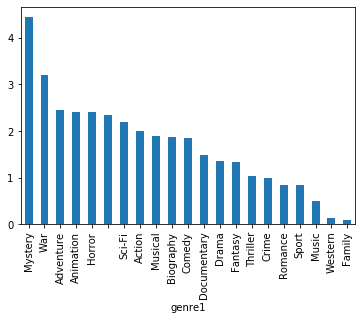

In [186]:
genre_vs_mom.plot.bar()

In [222]:
genre2_vs_mom

genre2
Mystery        2.920
Music          2.750
Animation      2.680
Adventure      2.470
Documentary    2.250
Romance        2.140
Sci-Fi         2.080
Comedy         2.050
Family         1.850
Fantasy        1.545
Drama          1.520
Crime          1.495
Horror         1.430
Thriller       1.390
Western        1.165
Sport          1.020
History        0.865
Biography      0.615
War            0.355
Musical          NaN
Name: global_mom, dtype: float64

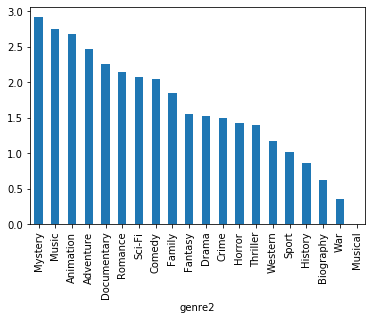

In [223]:
genre2_vs_mom.plot.bar()

### Notes

In [ ]:
# Use below three tables to do earnings / ROI by genre by season

In [ ]:
SELECT COUNT(*) 
FROM movies.imdb_title_basics
WHERE start_year > 2010
#total 146144 rows --> starts 2010 only 

In [ ]:
SELECT COUNT(*)
FROM movies.bom_movie_gross
# total 3387 rows --> total database only has 3387 rows and starts at 2010

In [ ]:
# tn movie budgets; bom movie gross; tmbd movies with unique titles 

In [ ]:
SELECT 
	COUNT(*),
    RIGHT(release_date, 4)
FROM movies.tn_movie_budgets
GROUP BY RIGHT(release_date, 4) ASC
#5782 rows total --> 1996 first year with over 100 movies 

SELECT 
	COUNT(*)
FROM movies.tn_movie_budgets
WHERE RIGHT(release_date, 4) > 1995
#4925
#2194 for 2010 and after

In [1]:
#GENERAL Analysis (JOIN ON Movie name)
#earnings / ROI by genre (tn_movie_budgets + imdb_title_basics JOIN on movie title) POST 2010 (only 2194 movies)
#earnings / ROI by season (use only tn_movie_budgets) POST 2010 (only 2194 movies)
#ratings vs. box office success correlatoin (movie_budgets and title_basics)
#IMDB analysis (JOIN ON nmstat and tstat)
#imdb genre vs. rating (use title_basics, title_ratings JOIN on tconst) POST 2010 (limit is ratings)
#imdb actors, directors and producers with highest ratings (use title_principals, title_ratings and 
#name_basics, JOIN on tconst and nmconst) POST 2010 (limit is ratings)
#RT Analysis (JOIN ON ID)
#overview of top critics, most frequent critics and what genres they like / how harsh they are (rt_reviews)
#rt ratings vs. box office reviews vs. top critics (1500 instances approx) limited by box office numbers in movie_info

In [ ]:
# LIST of databases
## DONT USE movies.bom_movie_gross for anything 
## DONT USE movies.imdb_name basics
## DONT USE imdb title akas
## DONT USE imdb title crew
## ONLY database with too many rows is imdb principles w/ over 1m 

In [ ]:
# TO DO
## Split genre into Primary, Secondary, Tertiary (for both ImDB and RT)